# **<span style="color:White;">Scaling, Imputing and Heatmaps with Supervised Learning</span>**

## **Purpose of Notebook**
Loading the cleaned Dataset, Encoding and Scaling Functions, Imputing missing values, Sampling Techniques, Correlation Heatmap

---

## **Contents of notebook**
### **Section 1: Loading and Merging Dataset**
```python 
- [x] Loading the datasets
- [x] Look at the shape of the cleaned dataframes
- [x] Split Columns based on Datatypes
```

**Import Necessary Libraries and Modules**

In [131]:
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
)
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error,
    silhouette_score
)
from sklearn.metrics import jaccard_score

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error,
    silhouette_score
)
from sklearn.metrics import jaccard_score
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor



## **<span style="color:white;">Section 1: Loading Datasets and General Check</span>**

**Loading Cleaned Datasets**

In [132]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')
# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')
UK_data = UK_data.drop(['latitude', 'longitude'], axis=1)

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4353, 21)
UK Dataset Shape: (229782, 21)


**Splitting Columns into Datatypes**

In [133]:
# Identify numerical and categorical columns
# treating speed limit as categorical numerical_columns 
categorical_columns = ['Posted Speed Limit (MPH)'
    'Make', 'Model', 'ADS Equipped?','Model Year'
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country']
datetime_columns = ['Incident Date','Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']

## **<span style="color:white;">Section 2: Assessing Missing Values</span>**

**How much missing Data**
- if we drop the values recorded by the organisation as unknown we will get less than 1800 rows from the original 4000 size
- recording unknown and being missing is 2 different things
- imputing could add a lot of errors possibly 
- unknown can be handled by some models and is there a reason why it is even unknown in the first place? 
- if high accuracy imputing when we could use that method or treat unknown as it's own catergory

In [134]:
def display_missing_and_unknown_separate(dataset, dataset_name):
    """
    Purpose: 
    Reference:
    """
    # Columns that have missing or unknown values
    features_with_issues = [
        col for col in dataset.columns
        if dataset[col].isnull().sum() > 0 

    ]
    
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage Missing"]
    
    for col in features_with_issues:
        missing_pct = np.round(dataset[col].isnull().mean() * 100, 2)
        table.add_row([col, f"{missing_pct} %"])
    
    print(f"Missing' Values in {dataset_name}:")
    print(table)

# Usage:
display_missing_and_unknown_separate(UK_data, "UK Dataset")
display_missing_and_unknown_separate(US_data, "US Dataset")

Missing' Values in UK Dataset:
+---------+--------------------+
| Feature | Percentage Missing |
+---------+--------------------+
+---------+--------------------+
Missing' Values in US Dataset:
+---------------------------------+--------------------+
|             Feature             | Percentage Missing |
+---------------------------------+--------------------+
|               Make              |       0.02 %       |
|              Model              |       0.05 %       |
|            Model Year           |       0.3 %        |
|    Automation System Engaged?   |       4.99 %       |
|      Incident Time (24:00)      |       4.18 %       |
|               City              |       1.7 %        |
|           Roadway Type          |       13.6 %       |
|         Roadway Surface         |      19.16 %       |
|     Posted Speed Limit (MPH)    |      10.98 %       |
|             Lighting            |      19.32 %       |
|            Crash With           |      20.93 %       |
| Highes

In [135]:
# Drop rows with NaN values in the specified columns
cols_to_check = ['Make', 'Model', 'Model Year', 'Automation System Engaged?', 'Incident Time (24:00)', 'City']
US_data = US_data.dropna(subset=cols_to_check)

# Display the new shape
print("Shape after dropping rows with NaNs in specified columns:", US_data.shape)
US_data.head()

Shape after dropping rows with NaNs in specified columns: (4032, 21)


,Report ID,Report Version,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
6,10039-10316,4,BMW,XM,2023.0,No,ADAS,2025-03-25,14:06:00,Benton County,AR,Highway / Freeway,NaN,65.0,NaN,First Responder Vehicle,Minor,NaN,NaN,"Back, Front",US
9,10039-3997,3,BMW,X5 sDrive40i,2020.0,No,ADAS,2025-05-22,22:25:00,Refugio,TX,Highway / Freeway,NaN,75.0,NaN,Pole / Tree,Serious,Proceeding Straight,Clear,Front,US
10,10039-4636,4,BMW,X5,2022.0,No,ADAS,2025-12-22,07:05:00,Fairfield,CA,Highway / Freeway,NaN,NaN,NaN,Other Fixed Object,Minor,Lane / Road Departure,NaN,Front,US
15,10039-6833,4,BMW,iX xDrive50,2023.0,No,ADAS,2025-12-23,06:00:00,Bel Air,MD,Highway / Freeway,NaN,NaN,"Other, see Narrative",Other Fixed Object,No Injuries Reported,Proceeding Straight,Fog/Smoke,"Back, Front, Nearside",US
17,10039-8,3,BMW,X5 xDrive40i,2019.0,No,ADAS,2025-07-21,03:01:00,Miami,FL,Highway / Freeway,NaN,NaN,"Other, see Narrative","Other, see Narrative",Minor,Changing Lanes,Other,"Back, Front, Offside",US


In [136]:
cols_to_impute = [
     'Roadway Type', 'Roadway Surface', 
    'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 
    'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 
    'SV Contact Area'
]


**Converting Posted Speed Limit to Catergorical**
- want to see the 10s (60s, 30s, 20s etc) it is in instead of a mean of 37.5 
- no need to encode beforehand 
- incident time is treated as numerical

In [137]:

# Option 1: Round to the nearest multiple of 5 (as the comment suggests)
US_data['Posted Speed Limit (MPH) Rounded'] = US_data['Posted Speed Limit (MPH)'].apply(
    lambda x: 10 * round(x / 10) if pd.notnull(x) else np.nan
)

# Option 2: Round to the nearest multiple of 10 (as your code was doing)
# US_data['Posted Speed Limit (MPH) Rounded'] = US_data['Posted Speed Limit (MPH)'].apply(
#     lambda x: 10 * round(x / 10) if pd.notnull(x) else np.nan
# )

# Convert to categorical with string labels, keeping NaN as NaN
US_data['Posted Speed Limit (MPH)'] = US_data['Posted Speed Limit (MPH) Rounded'].apply(
    lambda x: str(int(x)) if pd.notnull(x) else np.nan
)

# Convert to categorical
US_data['Posted Speed Limit (MPH)'] = US_data['Posted Speed Limit (MPH)'].astype('category')

# Drop the intermediate column
US_data.drop(columns=['Posted Speed Limit (MPH) Rounded'], inplace=True)

# Check the results
print("Speed limit categories after processing:")
print(US_data['Posted Speed Limit (MPH)'].value_counts().sort_index())

Speed limit categories after processing:
Posted Speed Limit (MPH)
0       17
10       7
20    1189
30     231
40     812
50      96
60    1102
70     233
80      76
Name: count, dtype: int64


**Imputation Methods**

In [138]:
def mode_impute(df, columns):
    """Simple mode imputation for categorical columns"""
    df_imputed = df.copy()
    for col in columns:
        if df[col].notna().sum() > 0:  # Only if there are non-null values
            mode_val = df[col].mode()
            if len(mode_val) > 0:
                df_imputed[col] = df[col].fillna(mode_val[0])
    return df_imputed
    
def locf_impute(df, columns):
    """Last Occurrence Carried Forward imputation"""
    df_imputed = df.copy()
    for col in columns:
        df_imputed[col] = df[col].ffill()  # Forward fill
        # If still NaN after forward fill, use backward fill
        df_imputed[col] = df_imputed[col].bfill()
    return df_imputed


In [139]:
# Random Forest imputation
def rf_impute(df, columns, multi_label_cols=None):
    """Random Forest imputation for numeric, categorical, and multi-label categorical data"""
    df_imputed = df.copy()
    multi_label_cols = multi_label_cols or []

    for col in columns:
        if df[col].isna().sum() == 0:
            continue
        if col in multi_label_cols:
            # Multi-label handling (simplified for this example)
            # Convert to most common category for simplicity
            mode_val = df[col].mode()
            if len(mode_val) > 0:
                df_imputed[col] = df[col].fillna(mode_val[0])
        else:
            # Standard RF imputation
            complete_cases = df.dropna(subset=[col])
            missing_mask = df[col].isna()
            
            if complete_cases.empty or missing_mask.sum() == 0:
                continue
                
            # Use numerical and categorical features for prediction
            feature_cols = [c for c in df.columns if c != col and df[c].notna().sum() > 0]
            
            if not feature_cols:
                # Fallback to mode if no features available
                mode_val = df[col].mode()
                if len(mode_val) > 0:
                    df_imputed[col] = df[col].fillna(mode_val[0])
                continue
            
            try:
                # Prepare features
                X_complete = pd.get_dummies(complete_cases[feature_cols], drop_first=True)
                X_missing = pd.get_dummies(df.loc[missing_mask, feature_cols], drop_first=True)
                
                # Align columns
                X_missing = X_missing.reindex(columns=X_complete.columns, fill_value=0)
                
                # Choose model based on data type
                is_numerical = pd.api.types.is_numeric_dtype(df[col])
                
                if is_numerical:
                    y = complete_cases[col].values
                    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=1)
                    model.fit(X_complete, y)
                    if not X_missing.empty:
                        preds = model.predict(X_missing)
                        df_imputed.loc[missing_mask, col] = preds
                else:
                    y = complete_cases[col].astype(str)
                    if len(y.unique()) > 1:  # Only if multiple categories
                        le = LabelEncoder()
                        y_encoded = le.fit_transform(y)
                        model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=1)
                        model.fit(X_complete, y_encoded)
                        if not X_missing.empty:
                            preds = model.predict(X_missing)
                            preds_decoded = le.inverse_transform(preds)
                            df_imputed.loc[missing_mask, col] = preds_decoded
                    else:
                        # Only one category, use mode
                        df_imputed.loc[missing_mask, col] = y.iloc[0]
                        
            except Exception as e:
                print(f"    RF failed for {col}, using mode: {str(e)}")
                mode_val = df[col].mode()
                if len(mode_val) > 0:
                    df_imputed[col] = df[col].fillna(mode_val[0])

    return df_imputed


In [140]:
# XGBoost imputation
def xgboost_impute(df, target_col, feature_cols=None):
    """XGBoost imputation for a single column"""
    df_imputed = df.copy()
    
    if df[target_col].isna().sum() == 0:
        return df_imputed
    
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != target_col and df[c].notna().sum() > 0]
    
    if not feature_cols:
        # Fallback to mode
        mode_val = df[target_col].mode()
        if len(mode_val) > 0:
            df_imputed[target_col] = df[target_col].fillna(mode_val[0])
        return df_imputed
    
    try:
        complete_mask = df[target_col].notna()
        missing_mask = df[target_col].isna()
        
        if complete_mask.sum() == 0 or missing_mask.sum() == 0:
            return df_imputed
        
        # Prepare data
        X_train = pd.get_dummies(df.loc[complete_mask, feature_cols], drop_first=True)
        X_missing = pd.get_dummies(df.loc[missing_mask, feature_cols], drop_first=True)
        
        # Align columns
        X_missing = X_missing.reindex(columns=X_train.columns, fill_value=0)
        
        # Clean column names for XGBoost
        X_train.columns = [str(c).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for c in X_train.columns]
        X_missing.columns = X_train.columns
        
        is_numerical = pd.api.types.is_numeric_dtype(df[target_col])
        
        if is_numerical:
            y_train = df.loc[complete_mask, target_col].values
            model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
            model.fit(X_train, y_train)
            if not X_missing.empty:
                preds = model.predict(X_missing)
                df_imputed.loc[missing_mask, target_col] = preds
        else:
            y_train = df.loc[complete_mask, target_col].astype(str)
            if len(y_train.unique()) > 1:
                le = LabelEncoder()
                y_encoded = le.fit_transform(y_train)
                model = xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, eval_metric='logloss')
                model.fit(X_train, y_encoded)
                if not X_missing.empty:
                    preds = model.predict(X_missing)
                    preds_decoded = le.inverse_transform(preds)
                    df_imputed.loc[missing_mask, target_col] = preds_decoded
            else:
                df_imputed.loc[missing_mask, target_col] = y_train.iloc[0]
                
    except Exception as e:
        print(f"    XGBoost failed for {target_col}, using mode: {str(e)}")
        mode_val = df[target_col].mode()
        if len(mode_val) > 0:
            df_imputed[target_col] = df[target_col].fillna(mode_val[0])
    
    return df_imputed


In [141]:
# Jaccard score calculation
def calculate_jaccard_score(y_true, y_pred, multi_label=False):
    """Calculate Jaccard score for single-label or multi-label data"""
    try:
        if multi_label:
            # For multi-label, convert strings to sets and calculate Jaccard
            def string_to_set(s):
                if pd.isna(s) or s == '':
                    return set()
                return set([x.strip() for x in str(s).split(',') if x.strip()])
            
            true_sets = [string_to_set(x) for x in y_true]
            pred_sets = [string_to_set(x) for x in y_pred]
            
            jaccard_scores = []
            for t_set, p_set in zip(true_sets, pred_sets):
                if len(t_set) == 0 and len(p_set) == 0:
                    jaccard_scores.append(1.0)
                elif len(t_set.union(p_set)) == 0:
                    jaccard_scores.append(0.0)
                else:
                    jaccard_scores.append(len(t_set.intersection(p_set)) / len(t_set.union(p_set)))
            
            return np.mean(jaccard_scores)
        else:
            # For single-label categorical
            if len(np.unique(y_true)) <= 2:
                # Binary case
                return jaccard_score(y_true, y_pred, average='binary', zero_division=0)
            else:
                # Multi-class case
                return jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    except:
        return np.nan

In [142]:
# Main evaluation function
def evaluate_all_imputations(df, columns, test_size=0.1, random_state=42, multi_label_cols=None):
    """
    Evaluates Mode, RF, LOCF, and XGBoost imputations.
    Returns a DataFrame with accuracy and Jaccard scores per column.
    """
    multi_label_cols = multi_label_cols or []
    results = []

    for col in columns:
        print(f"\nEvaluating: {col}")
        
        # Skip columns with insufficient data
        non_missing = df[col].notna()
        if non_missing.sum() < 50:
            print(f"  Skipping {col} - insufficient data ({non_missing.sum()} non-null values)")
            continue

        # Create test mask
        n_test = max(10, int(non_missing.sum() * test_size))
        test_indices = non_missing[non_missing].sample(n=min(n_test, non_missing.sum()), random_state=random_state).index
        original_values = df.loc[test_indices, col].copy()

        # Create artificial missing values
        temp_df = df.copy()
        temp_df.loc[test_indices, col] = np.nan

        # Initialize results for this column
        col_results = {
            'Column': col,
            'Test_Values_Count': len(test_indices),
            'Mode_Accuracy': np.nan,
            'RF_Accuracy': np.nan,
            'LOCF_Accuracy': np.nan,
            'XGB_Accuracy': np.nan,
            'Mode_Jaccard': np.nan,
            'RF_Jaccard': np.nan,
            'LOCF_Jaccard': np.nan,
            'XGB_Jaccard': np.nan
        }

        # ---- Mode Imputation ----
        try:
            mode_imp_df = mode_impute(temp_df, [col])
            mode_imp = mode_imp_df.loc[test_indices, col]
            
            col_results['Mode_Accuracy'] = (mode_imp == original_values).mean()
            col_results['Mode_Jaccard'] = calculate_jaccard_score(
                original_values, mode_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    Mode imputation failed: {str(e)}")

        # ---- Random Forest Imputation ----
        try:
            rf_imp_df = rf_impute(temp_df, [col], multi_label_cols=multi_label_cols)
            rf_imp = rf_imp_df.loc[test_indices, col]
            
            col_results['RF_Accuracy'] = (rf_imp == original_values).mean()
            col_results['RF_Jaccard'] = calculate_jaccard_score(
                original_values, rf_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    RF imputation failed: {str(e)}")

        # ---- LOCF Imputation ----
        try:
            locf_imp_df = locf_impute(temp_df, [col])
            locf_imp = locf_imp_df.loc[test_indices, col]
            
            col_results['LOCF_Accuracy'] = (locf_imp == original_values).mean()
            col_results['LOCF_Jaccard'] = calculate_jaccard_score(
                original_values, locf_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    LOCF imputation failed: {str(e)}")

        # ---- XGBoost Imputation ----
        try:
            xgb_imp_df = xgboost_impute(temp_df, target_col=col)
            xgb_imp = xgb_imp_df.loc[test_indices, col]
            
            if pd.api.types.is_numeric_dtype(df[col]):
                col_results['XGB_Accuracy'] = np.isclose(xgb_imp, original_values, atol=1e-2).mean()
            else:
                col_results['XGB_Accuracy'] = (xgb_imp == original_values).mean()
            
            col_results['XGB_Jaccard'] = calculate_jaccard_score(
                original_values, xgb_imp, multi_label=(col in multi_label_cols)
            )
        except Exception as e:
            print(f"    XGBoost imputation failed: {str(e)}")

        results.append(col_results)

    return pd.DataFrame(results)

In [143]:
# Results printing function
def print_imputation_results(results_df):
    """Print formatted results with highlighting of best methods"""
    if results_df.empty:
        print("No results to display.")
        return
        
    # Columns to format and highlight
    acc_cols = ['Mode_Accuracy', 'RF_Accuracy', 'LOCF_Accuracy', 'XGB_Accuracy']
    jac_cols = ['Mode_Jaccard', 'RF_Jaccard', 'LOCF_Jaccard', 'XGB_Jaccard']

    formatted_df = results_df.copy()

    # Format percentages
    for col in acc_cols + jac_cols:
        def fmt(x):
            return f"{x:.1%}" if pd.notna(x) else "N/A"
        formatted_df[col] = formatted_df[col].apply(fmt)

    # Highlight best method per row for accuracy
    def highlight_max_row(row, cols):
        vals = []
        for c in cols:
            val_str = row[c]
            if val_str == "N/A":
                vals.append(-1)
            else:
                vals.append(float(val_str.strip('%')))

        if max(vals) > 0:
            max_val = max(vals)
            highlighted = []
            for i, v in enumerate(vals):
                s = row[cols[i]]
                if v == max_val and v > 0:
                    s = f"**{s}**"
                highlighted.append(s)
            return highlighted
        else:
            return [row[c] for c in cols]

    # Apply highlighting
    formatted_df[acc_cols] = formatted_df.apply(
        lambda row: highlight_max_row(row, acc_cols), axis=1, result_type='expand'
    )
    formatted_df[jac_cols] = formatted_df.apply(
        lambda row: highlight_max_row(row, jac_cols), axis=1, result_type='expand'
    )

    print("\nImputation Comparison Results:")
    print("=" * 80)
    print(tabulate(
        formatted_df.sort_values('Test_Values_Count', ascending=False),
        headers='keys',
        tablefmt='github',
        showindex=False
    ))

In [144]:
# Best method selection function
def select_best_methods(results_df):
    """Select best method for each column based on accuracy"""
    method_assignments = {
        'mode_columns': [],
        'rf_columns': [],
        'locf_columns': [],
        'xgb_columns': []
    }
    
    for _, row in results_df.iterrows():
        col = row['Column']
        
        # Compare accuracies (ignore NaNs)
        accuracies = {
            'Mode': row['Mode_Accuracy'] if pd.notna(row['Mode_Accuracy']) else -1,
            'RF': row['RF_Accuracy'] if pd.notna(row['RF_Accuracy']) else -1,
            'LOCF': row['LOCF_Accuracy'] if pd.notna(row['LOCF_Accuracy']) else -1,
            'XGB': row['XGB_Accuracy'] if pd.notna(row['XGB_Accuracy']) else -1
        }
        
        best_method = max(accuracies, key=accuracies.get)
        
        if best_method == 'Mode':
            method_assignments['mode_columns'].append(col)
        elif best_method == 'RF':
            method_assignments['rf_columns'].append(col)
        elif best_method == 'LOCF':
            method_assignments['locf_columns'].append(col)
        elif best_method == 'XGB':
            method_assignments['xgb_columns'].append(col)
    
    return method_assignments

In [145]:

# Run the evaluation
results_df = evaluate_all_imputations(
    US_data,
    cols_to_impute,
    test_size=0.2,
    multi_label_cols=['SV Contact Area'] if 'SV Contact Area' in cols_to_impute else []
)

# %%
# Print and analyze results
print_imputation_results(results_df)

# %%
# Get best method assignments
best_methods = select_best_methods(results_df)
print("\nBest Methods Selected:")
for method, columns in best_methods.items():
    if columns:
        print(f"{method}: {columns}")

# %%
# Apply final imputation using best methods
final_imputed = US_data.copy()


Evaluating: Roadway Type

Evaluating: Roadway Surface

Evaluating: Posted Speed Limit (MPH)

Evaluating: Lighting

Evaluating: Crash With

Evaluating: Highest Injury Severity Alleged

Evaluating: SV Pre-Crash Movement

Evaluating: Weather

Evaluating: SV Contact Area

Imputation Comparison Results:
| Column                          |   Test_Values_Count | Mode_Accuracy   | RF_Accuracy   | LOCF_Accuracy   | XGB_Accuracy   | Mode_Jaccard   | RF_Jaccard   | LOCF_Jaccard   | XGB_Jaccard   |
|---------------------------------|---------------------|-----------------|---------------|-----------------|----------------|----------------|--------------|----------------|---------------|
| Posted Speed Limit (MPH)        |                 752 | 30.9%           | **68.6%**     | 43.2%           | 68.2%          | 3.4%           | 25.3%        | 13.4%          | **28.2%**     |
| Roadway Type                    |                 706 | 36.1%           | **75.8%**     | 49.0%           | 74.1%        

In [146]:
# Apply Random Forest imputation to all specified columns
US_final_imputed = US_data.copy()

for col in cols_to_impute:
    print(f"Applying XGBoost imputation to: {col}")
    US_final_imputed = xgboost_impute(US_final_imputed, target_col=col)

print(f"Final imputed data shape: {US_final_imputed.shape}")

Applying XGBoost imputation to: Roadway Type
Applying XGBoost imputation to: Roadway Surface
Applying XGBoost imputation to: Posted Speed Limit (MPH)
Applying XGBoost imputation to: Lighting
Applying XGBoost imputation to: Crash With
Applying XGBoost imputation to: Highest Injury Severity Alleged
Applying XGBoost imputation to: SV Pre-Crash Movement
Applying XGBoost imputation to: Weather
Applying XGBoost imputation to: SV Contact Area
Final imputed data shape: (4032, 21)


In [147]:
print(f"Remaining missing values: {US_final_imputed.isnull().sum().sum()}")
display_missing_and_unknown_separate(US_final_imputed, "Imputed US Dataset")

Remaining missing values: 0
Missing' Values in Imputed US Dataset:
+---------+--------------------+
| Feature | Percentage Missing |
+---------+--------------------+
+---------+--------------------+


In [148]:
US_final_imputed.head()

,Report ID,Report Version,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
6,10039-10316,4,BMW,XM,2023.0,No,ADAS,2025-03-25,14:06:00,Benton County,AR,Highway / Freeway,Dry,60,Daylight,First Responder Vehicle,Minor,Proceeding Straight,Clear,"Back, Front",US
9,10039-3997,3,BMW,X5 sDrive40i,2020.0,No,ADAS,2025-05-22,22:25:00,Refugio,TX,Highway / Freeway,Dry,80,Daylight,Pole / Tree,Serious,Proceeding Straight,Clear,Front,US
10,10039-4636,4,BMW,X5,2022.0,No,ADAS,2025-12-22,07:05:00,Fairfield,CA,Highway / Freeway,Dry,60,Dark - Not Lighted,Other Fixed Object,Minor,Lane / Road Departure,Clear,Front,US
15,10039-6833,4,BMW,iX xDrive50,2023.0,No,ADAS,2025-12-23,06:00:00,Bel Air,MD,Highway / Freeway,Dry,60,"Other, see Narrative",Other Fixed Object,No Injuries Reported,Proceeding Straight,Fog/Smoke,"Back, Front, Nearside",US
17,10039-8,3,BMW,X5 xDrive40i,2019.0,No,ADAS,2025-07-21,03:01:00,Miami,FL,Highway / Freeway,Dry,60,"Other, see Narrative","Other, see Narrative",Minor,Changing Lanes,Other,"Back, Front, Offside",US


## **<span style="color:white;">Section X: Encoding and Scaling</span>**
- label encoding has high cardinality

In [152]:
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import pandas as pd

# === Define columns ===
categorical_columns = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State','Country','Report ID', 'Report Version',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area','Crash With'
]

datetime_cols = ['Incident Date', 'Incident Time (24:00)']
numerical_cols = []  # Add real numerical columns here if any
index_cols = ['Report ID', 'Report Version']


def encode_data(df, categorical_cols, datetime_cols, numerical_cols, index_cols):
    """
    Encodes categorical columns using LabelEncoder and datetime columns as numeric values.
    """
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd

    df_encoded = df.copy()
    encoders = {}

    # Encode categorical columns
    for col in categorical_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype(str).fillna("Unknown")
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoders[col] = le

    # Convert datetime columns to numeric formats
    if 'Incident Date' in datetime_cols and 'Incident Date' in df_encoded.columns:
        df_encoded['Incident Date'] = pd.to_datetime(df_encoded['Incident Date'], errors='coerce')
        df_encoded['Incident_Year'] = df_encoded['Incident Date'].dt.year
        df_encoded['Incident_Month'] = df_encoded['Incident Date'].dt.month
        df_encoded['Incident_DayOfWeek'] = df_encoded['Incident Date'].dt.dayofweek
        df_encoded.drop(columns=['Incident Date'], inplace=True)

    if 'Incident Time (24:00)' in datetime_cols and 'Incident Time (24:00)' in df_encoded.columns:
        time_parsed = pd.to_datetime(df_encoded['Incident Time (24:00)'], format='%H:%M:%S', errors='coerce')
        df_encoded['Incident Time (24:00)'] = (
            time_parsed.dt.hour.fillna(0).astype(int) * 3600 +
            time_parsed.dt.minute.fillna(0).astype(int) * 60 +
            time_parsed.dt.second.fillna(0).astype(int)
        )


    return df_encoded, encoders


# === Encode both datasets ===
US_encoded_df, us_encoders = encode_data(
    df=US_final_imputed,
    categorical_cols=categorical_columns,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

UK_encoded_df, uk_encoders = encode_data(
    df=UK_data,
    categorical_cols=categorical_columns,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

# === Preview ===
print("US Data Shape:", US_encoded_df.shape)
print("UK Data Shape:", UK_encoded_df.shape)
print("\nUK Preview:")
print(tabulate(UK_encoded_df.head(), headers='keys', tablefmt='pretty'))

print("\nUS Preview:")
print(tabulate(US_encoded_df.head(), headers='keys', tablefmt='pretty'))


US Data Shape: (4032, 23)
UK Data Shape: (229782, 23)

UK Preview:
+---+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+------+-------+--------------+-----------------+--------------------------+----------+------------+---------------------------------+-----------------------+---------+-----------------+---------+---------------+----------------+--------------------+
|   | Report ID | Report Version | Make | Model | Model Year | ADS Equipped? | Automation System Engaged? | Incident Time (24:00) | City | State | Roadway Type | Roadway Surface | Posted Speed Limit (MPH) | Lighting | Crash With | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather | SV Contact Area | Country | Incident_Year | Incident_Month | Incident_DayOfWeek |
+---+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+------+-------+--------------+----------

## **<span style="color:white;">Section X: Heatmap</span>**

In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_with_severity_corr(encoded_df, target_col='Highest Injury Severity Alleged', index_cols=None, 
                                    figsize=(20, 16), annot=True, cmap='coolwarm', fmt='.2f'):
    """
    Purpose: Plots a correlation heatmap from an encoded DataFrame and prints
             top 10 absolute correlations with a target column (e.g., 'severity').
    
    Parameters:
    - encoded_df: DataFrame with numeric features.
    - target_col: The column name to compute correlation against (default: 'severity').
    - index_cols: Columns to exclude from correlation (e.g., IDs, indexes).
    - figsize: Size of the heatmap.
    - annot: Whether to annotate heatmap cells.
    - cmap: Color map for heatmap.
    - fmt: Format of annotations.
    """
    
    # Determine columns to include
    plot_cols = [col for col in encoded_df.columns 
                 if col not in (index_cols or []) 
                 and pd.api.types.is_numeric_dtype(encoded_df[col])]
    
    if not plot_cols:
        raise ValueError("No numeric columns available for correlation calculation")
    
    # Correlation matrix
    corr_matrix = encoded_df[plot_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, center=0, fmt=fmt,
                linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Heatmap', pad=20, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Get top 10 absolute correlations with target column
    if target_col not in corr_matrix.columns:
        raise ValueError(f"Target column '{target_col}' not found in correlation matrix")
    
    abs_corr = corr_matrix[target_col].drop(target_col).abs()
    top10 = abs_corr.sort_values(ascending=False).head(10)
    
    print("\n🔝 Top 10 Features with Highest Absolute Correlation to '{}':\n".format(target_col))
    # Drop rows with any NaNs in selected columns
    corr_data = encoded_df[plot_cols].dropna()
    n_rows = corr_data.shape[0]
    print(f"\n📊 Number of rows used in correlation calculation: {n_rows}")

    return top10



**US Heatmap**
- much less columns hence correlations are stronger
- adas, ads and make, model also obviously correlated

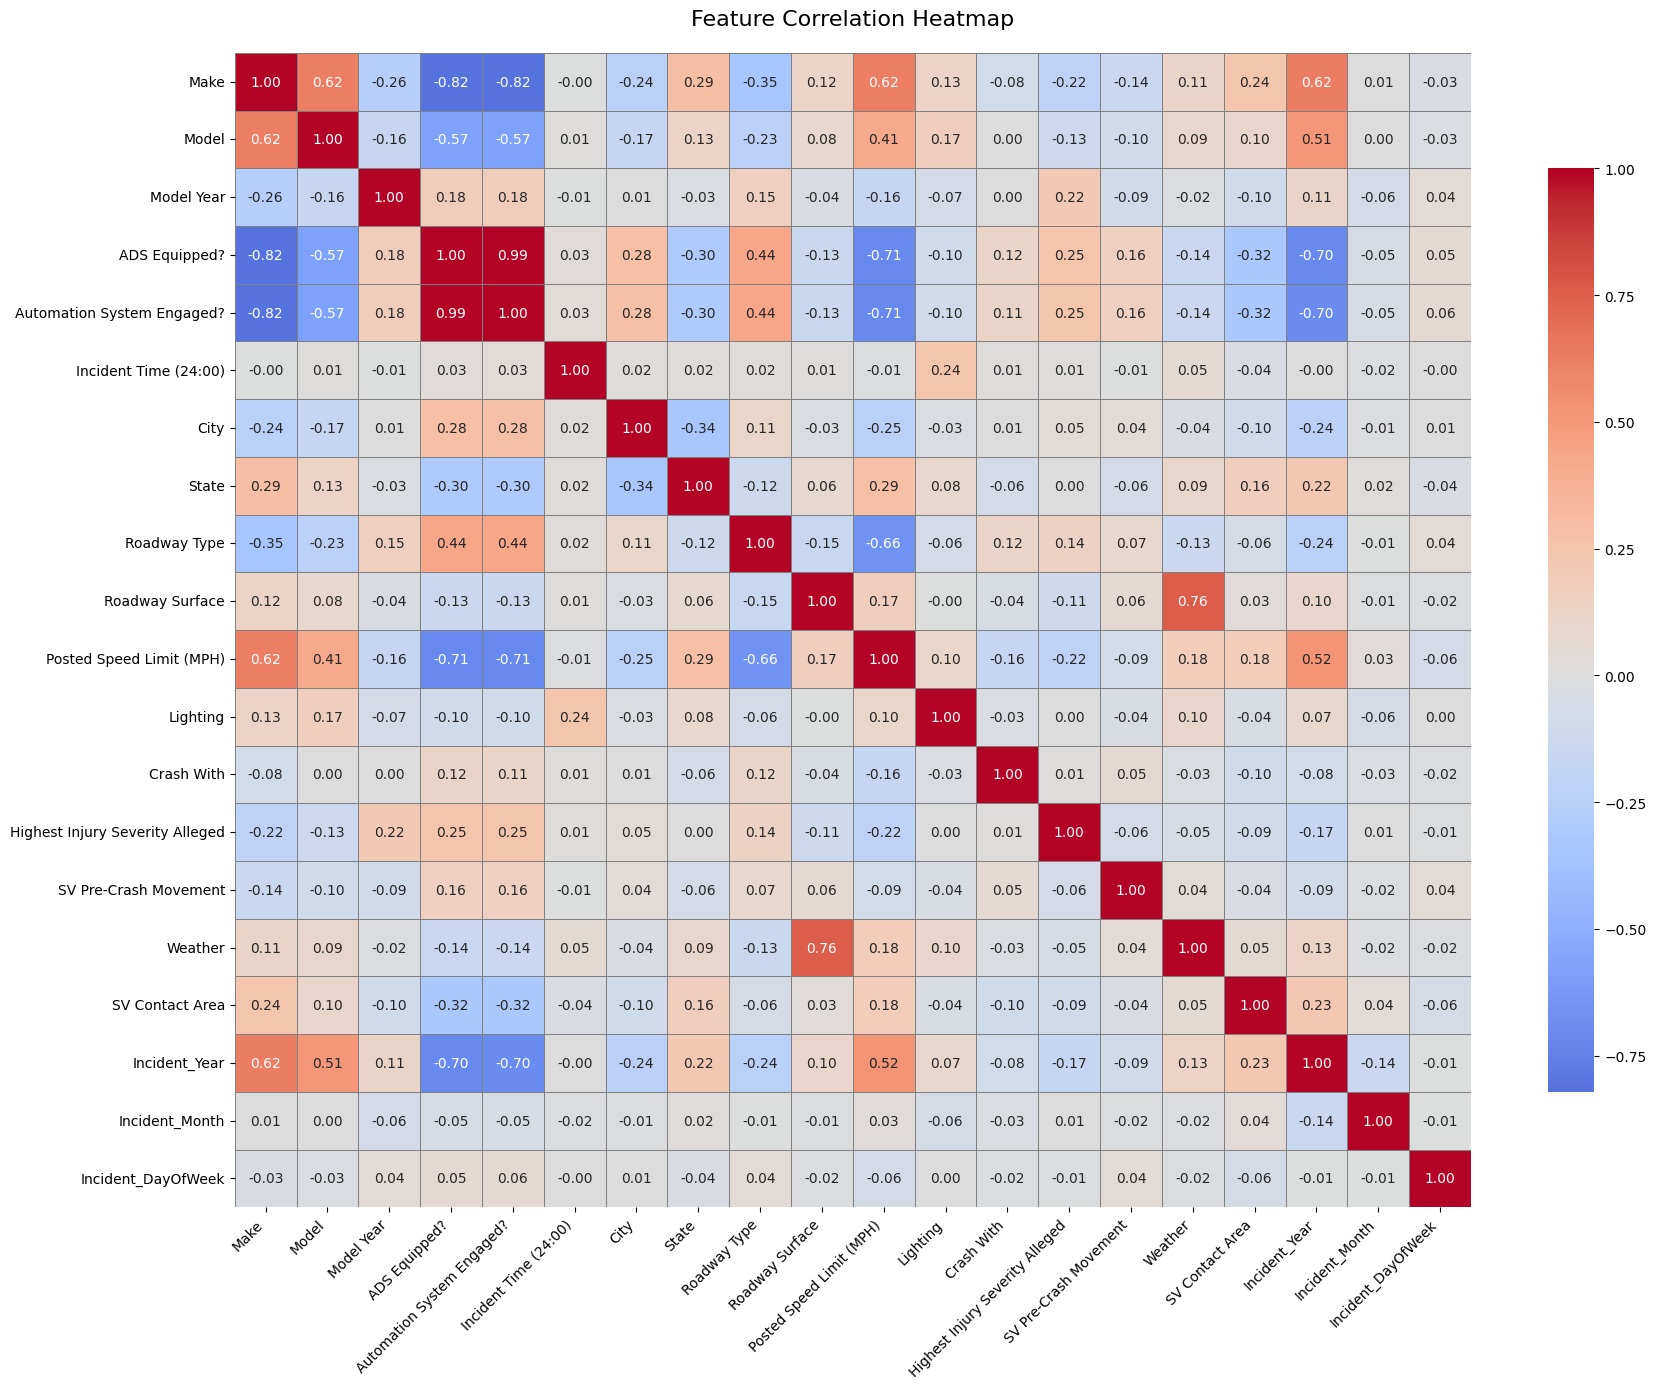


🔝 Top 10 Features with Highest Absolute Correlation to 'Highest Injury Severity Alleged':


📊 Number of rows used in correlation calculation: 4032


ADS Equipped?                 0.245979
Automation System Engaged?    0.245132
Posted Speed Limit (MPH)      0.216305
Make                          0.215623
Model Year                    0.215078
Incident_Year                 0.173924
Roadway Type                  0.138621
Model                         0.125326
Roadway Surface               0.114734
SV Contact Area               0.094822
Name: Highest Injury Severity Alleged, dtype: float64

In [154]:
# Plot heatmap from the encoded data
import matplotlib.pyplot as plt
drop_cols_us = ['Country','Report Version','Report ID']
plot_heatmap_with_severity_corr(
    encoded_df=US_encoded_df,
    index_cols=drop_cols_us,
    figsize=(18, 14),  # Customize size
    annot=True,        # Show correlation values   
)

**UK Heatmap**
- incident year is in report id hence corelated

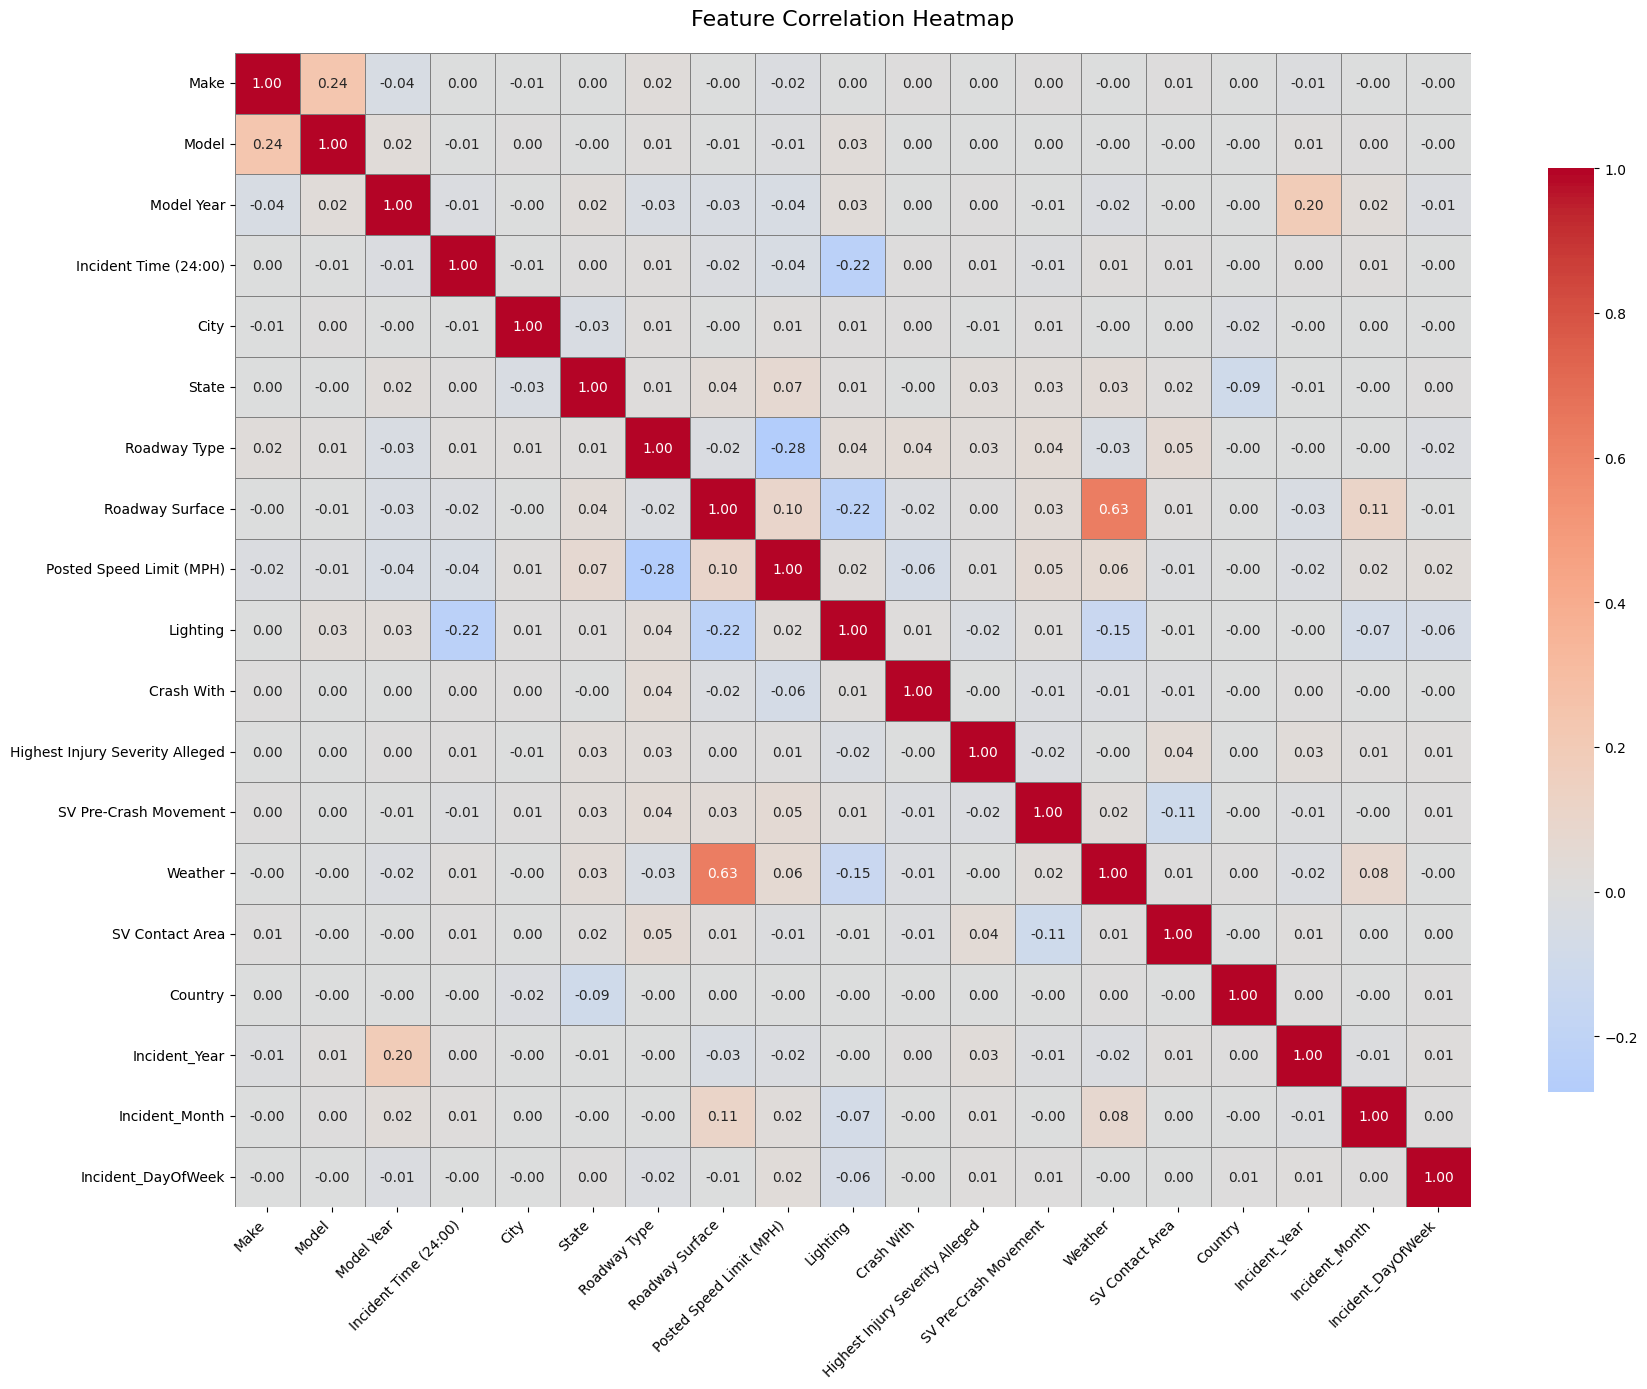


🔝 Top 10 Features with Highest Absolute Correlation to 'Highest Injury Severity Alleged':


📊 Number of rows used in correlation calculation: 229782


SV Contact Area          0.044122
Roadway Type             0.030824
Incident_Year            0.030526
State                    0.026601
Lighting                 0.023817
SV Pre-Crash Movement    0.017140
Incident_DayOfWeek       0.010381
Incident_Month           0.009147
Incident Time (24:00)    0.006566
City                     0.006298
Name: Highest Injury Severity Alleged, dtype: float64

In [155]:
# Plot heatmap from the encoded data
drop_cols_uk = ['ADS Equipped?','Automation System Engaged?','Report Version','Report ID']
plot_heatmap_with_severity_corr(
    encoded_df=UK_encoded_df,
    index_cols=drop_cols_uk,
    figsize=(18, 14),  # Customize size
    annot=True,        # Show correlation values
)

## **<span style="color:white;">Section X: Saving Encoded and Scaled Datasets</span>**

In [156]:
# the imputed
US_final_imputed.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv', index=False)

In [157]:
# encoded and scaled
US_scaled_df.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_scaled_data.csv', index=False)
UK_scaled_df.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_scaled_data.csv', index=False)